In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 路径声明

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 设定分类数

In [3]:
NUM_CLASSES = 8

# 读取学习数据

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
# 读入从1到21*2的数据（表的每行共有21个数据（对应21个特征点） 每个数据有两个值（xy坐标轴值））作为x

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
# 第0列的值代表属于哪种手势

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 模型构建

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 模型检查点回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 用于提前结束的回调
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# 模型编译
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 模型训练

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=12000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

uracy: 0.5430 - val_loss: 0.7505 - val_accuracy: 0.8033

Epoch 00043: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 44/12000
68/68 [==============================] - 0s 7ms/step - loss: 1.1481 - accuracy: 0.5505 - val_loss: 0.7540 - val_accuracy: 0.8147

Epoch 00044: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 45/12000
68/68 [==============================] - 0s 6ms/step - loss: 1.1341 - accuracy: 0.5501 - val_loss: 0.7445 - val_accuracy: 0.8043

Epoch 00045: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 46/12000
68/68 [==============================] - 0s 6ms/step - loss: 1.1289 - accuracy: 0.5502 - val_loss: 0.7309 - val_accuracy: 0.8109

Epoch 00046: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 47/12000
68/68 [==============================] - 0s 6ms/step - loss: 1.1305 - accuracy: 0.5425 - val_loss: 0.7341 - val_accuracy: 0.8199

Epoch 00047: saving model to model/keypoint

In [14]:
# 模型评估
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

23/23 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.8671


In [15]:
# 加载保存的模型
model = tf.keras.models.load_model(model_save_path)

In [16]:
# 推理测试
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.10307282 0.04440359 0.0008756  0.0104354  0.6322752  0.15277313
 0.04367717 0.01248706]
4


# 混淆矩阵

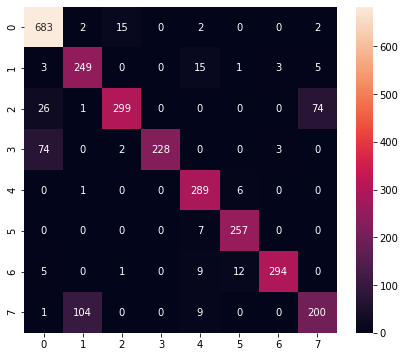

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       704
           1       0.70      0.90      0.79       276
           2       0.94      0.75      0.83       400
           3       1.00      0.74      0.85       307
           4       0.87      0.98      0.92       296
           5       0.93      0.97      0.95       264
           6       0.98      0.92      0.95       321
           7       0.71      0.64      0.67       314

    accuracy                           0.87      2882
   macro avg       0.87      0.86      0.86      2882
weighted avg       0.88      0.87      0.87      2882



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# 转化为Tensorflow-Lite用模型

In [18]:
# 保存为仅供推理的模型
model.save(model_save_path, include_optimizer=False)

In [19]:
# 转换模型（量化）
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\fxf20\AppData\Local\Temp\tmpi_nfk8ca\assets


6528

# 推理测试

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# 获取 I/O 张量
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# 推理实施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.10307287 0.0444036  0.0008756  0.01043539 0.6322751  0.15277317
 0.04367717 0.01248705]
4
